# Online Retail Dataset: RFM Scores

In this notebook, I'll use the prepared dataset to compute the RFM scores.

## Imports

In [1]:
from pathlib import Path
from typing import Literal, cast, get_args

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.ticker import AutoMinorLocator
from pandas.testing import assert_frame_equal, assert_index_equal, assert_series_equal

from utils.rfm import RFMAttribute, add_rfm_scores

## Read prepared dataset

In [2]:
# File path for dataset
file_path = Path.cwd().parents[1] / "data" / "online_retail.csv"
assert file_path.exists(), f"file doesn't exist: {file_path}"
assert file_path.is_file(), f"not a file: {file_path}"

In [3]:
df = pd.read_csv(
    file_path,
    dtype={
        "InvoiceNo": "category",
        "CustomerID": "category",
        "TotalPrice": np.float_,
    },
    parse_dates=["InvoiceDate"],
)
df.head(15)

,InvoiceNo,InvoiceDate,CustomerID,TotalPrice
0,536365,2010-12-01,17850,139.12
1,536366,2010-12-01,17850,22.20
2,536367,2010-12-01,13047,278.73
3,536368,2010-12-01,13047,70.05
4,536369,2010-12-01,13047,17.85
5,536370,2010-12-01,12583,855.86
6,536371,2010-12-01,13748,204.00
7,536372,2010-12-01,17850,22.20
8,536373,2010-12-01,17850,259.86
9,536374,2010-12-01,15100,350.40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18532 entries, 0 to 18531
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    18532 non-null  category      
 1   InvoiceDate  18532 non-null  datetime64[ns]
 2   CustomerID   18532 non-null  category      
 3   TotalPrice   18532 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1)
memory usage: 669.8 KB


## Compute RFM attributes
### Recency

To calculate the recency, I'll pretend that I'm performing this analysis 1
day after the last piece of data was collected.

In [5]:
today = df["InvoiceDate"].max() + pd.Timedelta(days=1)
today = cast(pd.Timestamp, today)
today

Timestamp('2011-12-10 00:00:00')

Recall that, in this case, recency corresponds to the number of days since
the last purchase. Figuring out the best way to compute this metric:

In [6]:
# Recency for a particular customer
(today - df.loc[df["CustomerID"] == "14688", "InvoiceDate"].max()).days

8

In [7]:
# Recency for all customers
recency = (today - df.groupby(by="CustomerID", observed=True).InvoiceDate.max()).dt.days
recency = cast(pd.Series, recency)

assert (recency > 0).all()

recency.head()

CustomerID
12346    326
12347      3
12348     76
12349     19
12350    311
Name: InvoiceDate, dtype: int64

In [8]:
recency.loc["14688"]

8

This seems OK. Then I'll start building the DataFrame that will store the RFM
scores:

In [9]:
df_rfm = (
    df.groupby(by="CustomerID", observed=True)
    .InvoiceDate.max()
    .to_frame()
    .rename(columns={"InvoiceDate": "LastPurchaseDate"})
)
df_rfm = cast(pd.DataFrame, df_rfm)

df_rfm["Recency"] = (today - df_rfm["LastPurchaseDate"]).dt.days
df_rfm = df_rfm.drop(columns="LastPurchaseDate")

df_rfm.head()

,Recency
CustomerID,
12346,326
12347,3
12348,76
12349,19
12350,311


### Frequency

Here I'll use the following definition of frequency: for a given customer,
frequency is the total number of purchases he/she made. Figuring out the best
way to evaluate this metric:

In [10]:
# Frequency for a particular customer
df[df["CustomerID"] == "14688"].shape[0]

21

In [11]:
df.loc[df["CustomerID"] == "14688", "InvoiceNo"].nunique()

21

In [12]:
# Frequency for all customers
freq_1 = df.groupby(by="CustomerID", observed=True).InvoiceNo.count()
freq_1 = cast(pd.Series, freq_1)
freq_1.name = "Frequency"
freq_1.head()

CustomerID
12346    1
12347    7
12348    4
12349    1
12350    1
Name: Frequency, dtype: int64

In [13]:
freq_1.loc["14688"]

21

In [14]:
freq_2 = df.groupby(by="CustomerID", observed=True).InvoiceNo.nunique()
freq_2 = cast(pd.Series, freq_2)
freq_2.name = "Frequency"
freq_2.head()

CustomerID
12346    1
12347    7
12348    4
12349    1
12350    1
Name: Frequency, dtype: int64

In [15]:
assert_series_equal(freq_1, freq_2)

The two methods used above are equivalent. Then I'll calculate the frequency
with the aid of the simplest one:

In [16]:
assert_index_equal(df_rfm.index, freq_1.index)

df_rfm["Frequency"] = df.groupby(by="CustomerID", observed=True).InvoiceNo.count()
df_rfm.head()

,Recency,Frequency
CustomerID,,
12346,326,1
12347,3,7
12348,76,4
12349,19,1
12350,311,1


### Monetary

Here I'll use the following definition of monetary: for a given customer,
monetary corresponds to the total amount spent by him/her. Figuring out the
best way to evaluate this quantity:

In [17]:
# Monetary for a particular customer
df.loc[df["CustomerID"] == "14688", "TotalPrice"].sum()

5630.87

In [18]:
# Monetary for all customers
monetary = df.groupby(by="CustomerID", observed=True).TotalPrice.sum()
monetary = cast(pd.Series, monetary)
monetary.head()

CustomerID
12346    77183.60
12347     4310.00
12348     1797.24
12349     1757.55
12350      334.40
Name: TotalPrice, dtype: float64

In [19]:
monetary.loc["14688"]

5630.87

Now that I understand how to perform the desired calculation, I'll add
monetary to my DataFrame:

In [20]:
assert_index_equal(df_rfm.index, monetary.index)

df_rfm["Monetary"] = df.groupby(by="CustomerID", observed=True).TotalPrice.sum()
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


In [21]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4338 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4338 non-null   int64  
 1   Frequency  4338 non-null   int64  
 2   Monetary   4338 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 273.1 KB


In [22]:
# Quick consistency checks
assert (df_rfm["Recency"] > 0).all()
assert (df_rfm["Frequency"] > 0).all()
assert (df_rfm["Monetary"] > 0.0).all()

### Summarizing through functions

At this point, all RFM attributes have been evaluated. Before proceeding,
let's collect the essential parts of the above code, and transform them into
a couple of functions.

In [23]:
def read_prepared_data(file_path: Path) -> pd.DataFrame:
    return pd.read_csv(
        file_path,
        dtype={
            "InvoiceNo": "category",
            "CustomerID": "category",
            "TotalPrice": np.float_,
        },
        parse_dates=["InvoiceDate"],
    )

In [24]:
def compute_rfm_attributes(df: pd.DataFrame) -> pd.DataFrame:
    customer_groups = df.groupby(by="CustomerID", observed=True)

    today = df["InvoiceDate"].max() + pd.Timedelta(days=1)
    today = cast(pd.Timestamp, today)

    df_rfm = customer_groups.InvoiceDate.max().to_frame().rename(columns={"InvoiceDate": "LastPurchaseDate"})
    df_rfm = cast(pd.DataFrame, df_rfm)
    df_rfm["Recency"] = (today - df_rfm["LastPurchaseDate"]).dt.days
    df_rfm = df_rfm.drop(columns="LastPurchaseDate")

    df_rfm["Frequency"] = customer_groups.InvoiceNo.count()
    df_rfm["Monetary"] = customer_groups.TotalPrice.sum()

    return df_rfm

In [25]:
# Quick tests
prepared_data = read_prepared_data(file_path)
assert_frame_equal(prepared_data, df)

In [26]:
rfm_attrs = compute_rfm_attributes(prepared_data)
assert_frame_equal(rfm_attrs, df_rfm)

In [27]:
del prepared_data
del rfm_attrs

## Compute RFM scores

Finally, it's possible to compute the RFM scores. To do so, I'll use the
`add_rfm_scores` function that I defined in the `utils` package:

In [28]:
df_rfm = add_rfm_scores(df_rfm)
df_rfm.head()

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMCell,RFMScore
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,5,"1,1,5",2.333333
12347,3,7,4310.00,5,5,5,"5,5,5",5.000000
12348,76,4,1797.24,2,4,4,"2,4,4",3.333333
12349,19,1,1757.55,4,1,4,"4,1,4",3.000000
12350,311,1,334.40,1,1,2,"1,1,2",1.333333


In [29]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4338 non-null   int64   
 1   Frequency  4338 non-null   int64   
 2   Monetary   4338 non-null   float64 
 3   RScore     4338 non-null   category
 4   FScore     4338 non-null   category
 5   MScore     4338 non-null   category
 6   RFMCell    4338 non-null   object  
 7   RFMScore   4338 non-null   float64 
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 354.2+ KB


## Save computed scores

In [30]:
# File path for output CSV
out_file = file_path.parent / "rfm_scores.csv"

df_rfm.to_csv(out_file, index=True)

## Visualization
### Recency and R score

Check that every bin contains approximately the same number of customers:

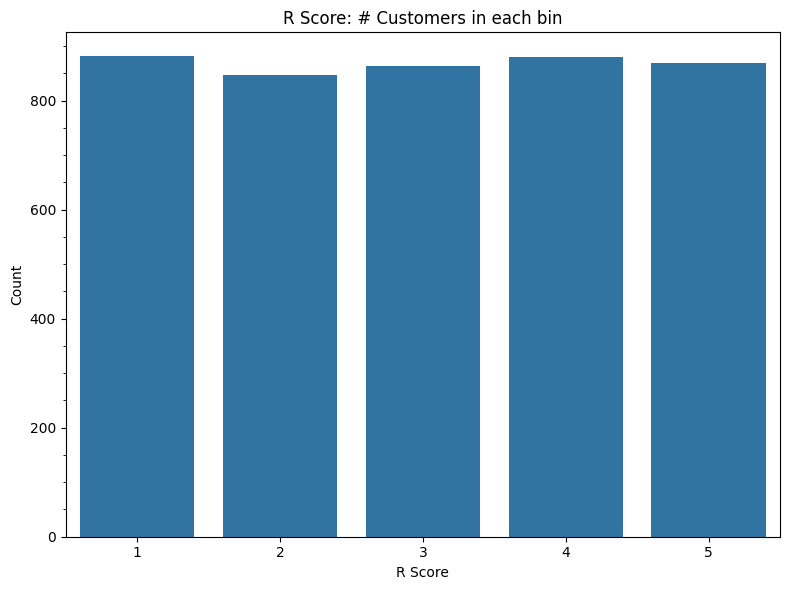

In [31]:
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.countplot(data=df_rfm, x="RScore", ax=ax)
ax.set_title("R Score: # Customers in each bin")
ax.set_xlabel("R Score")
ax.set_ylabel("Count")
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
plt.show()

In [32]:
# These are the values shown above:
df_rfm["RScore"].value_counts(sort=False)

RScore
1    881
2    846
3    863
4    880
5    868
Name: count, dtype: int64

Distribution of `Recency` for each R score:

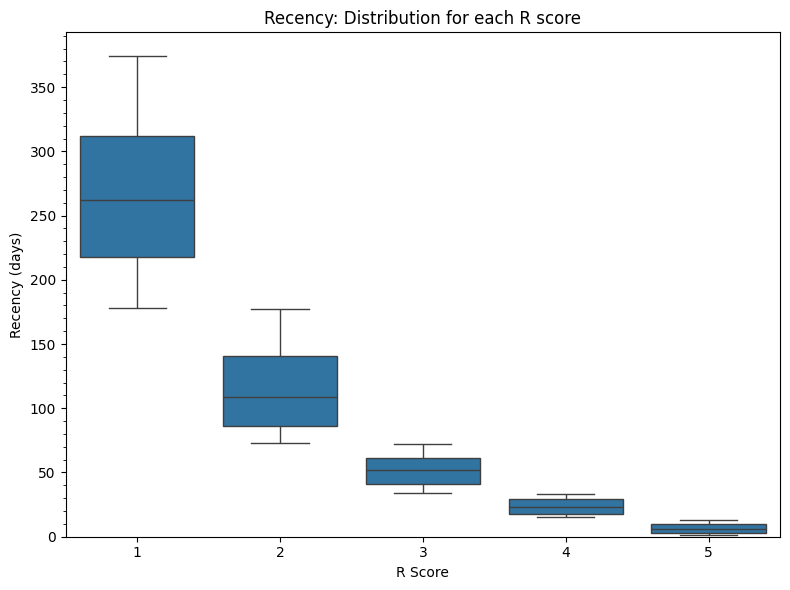

In [33]:
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.boxplot(data=df_rfm, x="RScore", y="Recency", ax=ax)
ax.set_title("Recency: Distribution for each R score")
ax.set_xlabel("R Score")
ax.set_ylabel("Recency (days)")
ax.set_ylim(bottom=0)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.show()

In [34]:
# Quick check
df_rfm.loc[df_rfm["RScore"] == 1, "Recency"].describe()

count    881.000000
mean     267.472191
std       57.888721
min      178.000000
25%      218.000000
50%      262.000000
75%      312.000000
max      374.000000
Name: Recency, dtype: float64

### Frequency and F score

Next, we're going to do something very similar to what we've done above. Then
it's convenient to use this code to define a couple of functions:

In [35]:
# Path to images directory
IMG_DIR = Path.cwd().parents[1] / "img"
assert IMG_DIR.exists(), f"directory doesn't exist: {IMG_DIR}"
assert IMG_DIR.is_dir(), f"not a directory: {IMG_DIR}"

In [36]:
def plot_bin_count(
    df: pd.DataFrame,
    score: Literal["R", "F", "M"],
    *,
    save: bool = False,
    figsize: tuple[float, float] = (8.0, 6.0),
) -> None:
    fig, ax = plt.subplots(figsize=figsize, layout="tight")
    ax = cast(Axes, ax)

    sns.countplot(data=df, x=f"{score}Score", ax=ax)
    ax.set_title(f"{score} Score: # Customers in each bin")
    ax.set_xlabel(f"{score} Score")
    ax.set_ylabel("Count")

    if save:
        out_img = IMG_DIR / f"bin_count_{score.lower()}score.png"
        fig.savefig(out_img)
        plt.close(fig)
    else:
        plt.show()

In [37]:
def plot_distribution_by_score(
    df: pd.DataFrame,
    attr: RFMAttribute,
    *,
    save: bool = False,
    figsize: tuple[float, float] = (8.0, 6.0),
) -> None:
    fig, ax = plt.subplots(figsize=figsize, layout="tight")
    ax = cast(Axes, ax)

    first_letter = attr[0]
    sns.boxplot(
        data=df,
        x=f"{first_letter}Score",
        y=attr,
        ax=ax,
        # I just want to know if the RFM attributes are distributed in a way
        # that makes sense. For this reason, I'll hide the outliers.
        showfliers=False,
    )
    ax.set_title(f"{attr}: Distribution for each {first_letter} score")
    ax.set_xlabel(f"{first_letter} Score")
    ax.set_ylim(bottom=0)

    match attr:
        case "Recency":
            unit = "days"
        case "Frequency":
            unit = "purchases"
        case "Monetary":
            unit = "£"
    ax.set_ylabel(f"{attr} ({unit})")

    if save:
        out_img = IMG_DIR / f"{attr.lower()}_distribution.png"
        fig.savefig(out_img)
        plt.close(fig)
    else:
        plt.show()

Using these functions to generate the desired plots:

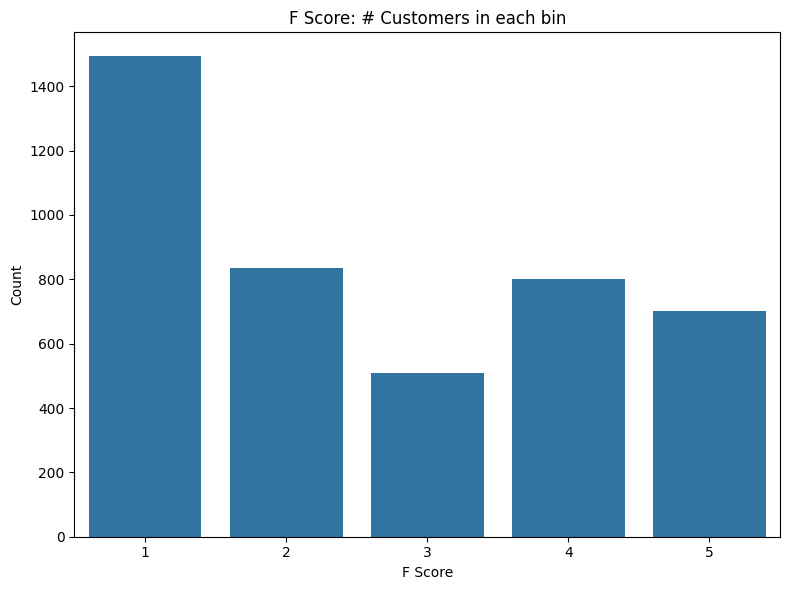

In [38]:
plot_bin_count(df_rfm, "F")

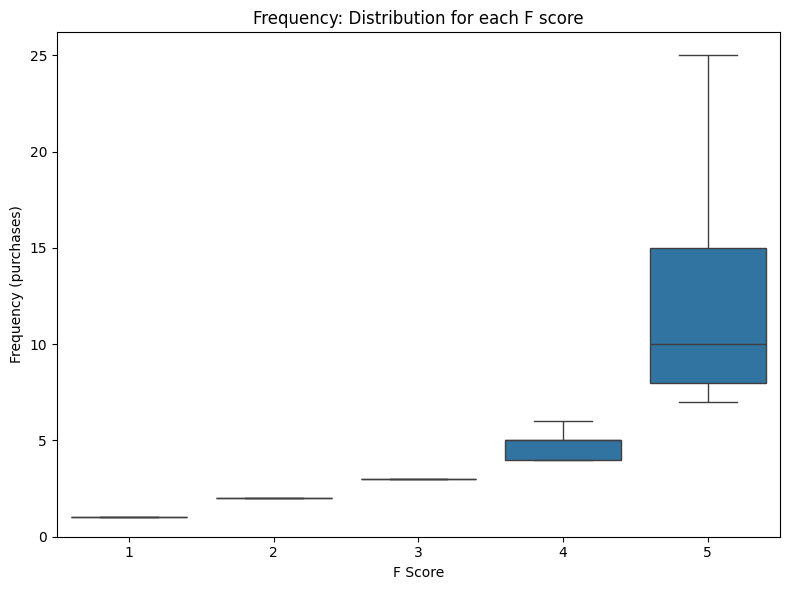

In [39]:
plot_distribution_by_score(df_rfm, "Frequency")

In the case of the F score, the number of customers in each bin varies
considerably. Basically, this imbalance is a consequence of the following
fact: **more than a third of customers only made a single purchase**. This
fact can be verified as follows:

In [40]:
df_rfm.Frequency.transform(lambda f: "1 purchase" if f == 1 else "2 or more purchases").value_counts(
    normalize=True, sort=False
).mul(100.0).transform(lambda p: f"{p:.2f}%")

Frequency
1 purchase             34.42%
2 or more purchases    65.58%
Name: proportion, dtype: object

In fact, all customers who purchased only once were assigned an F score of 1:

In [41]:
df_rfm.loc[df_rfm.FScore == 1, "Frequency"].unique()

array([1])

Something similar happened for F scores 2 and 3:

In [42]:
df_rfm.loc[df_rfm.FScore == 2, "Frequency"].unique()

array([2])

In [43]:
df_rfm.loc[df_rfm.FScore == 3, "Frequency"].unique()

array([3])

This is the reason why we see no variation in the first 3 boxplots above.

The `FScore = 4` case is the first that corresponds to more than one
`Frequency` value:

In [44]:
df_rfm.loc[df_rfm.FScore == 4, "Frequency"].value_counts()

Frequency
4    388
5    242
6    172
Name: count, dtype: int64

When `FScore = 5`, there's a lot more variation:

In [45]:
np.sort(df_rfm.loc[df_rfm.FScore == 5, "Frequency"].unique())

array([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  37,  38,  39,  41,  44,  45,  46,  47,  48,  50,
        51,  55,  57,  60,  62,  63,  73,  86,  91,  93,  97, 124, 201,
       209])

So it makes sense to recreate the above boxplot just for this case. This
time, we won't hide the outliers. The desired plot can be created as follows:

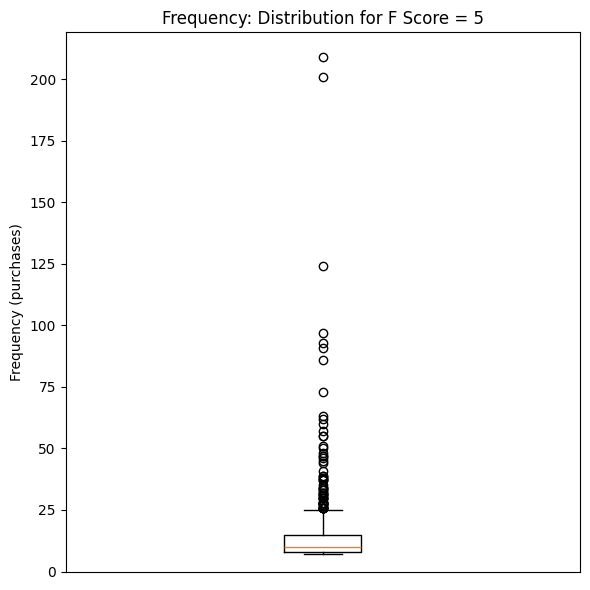

In [46]:
fig, ax = plt.subplots(figsize=(6.0, 6.0), layout="tight")
ax = cast(Axes, ax)
ax.boxplot(df_rfm.loc[df_rfm.FScore == 5, "Frequency"])
ax.set_title("Frequency: Distribution for F Score = 5")
ax.set_xticks([])
ax.set_ylabel("Frequency (purchases)")
ax.set_ylim(bottom=0)
plt.show()

A lot of what was presented above makes even more sense when we look at the
density estimate for `Frequency`:

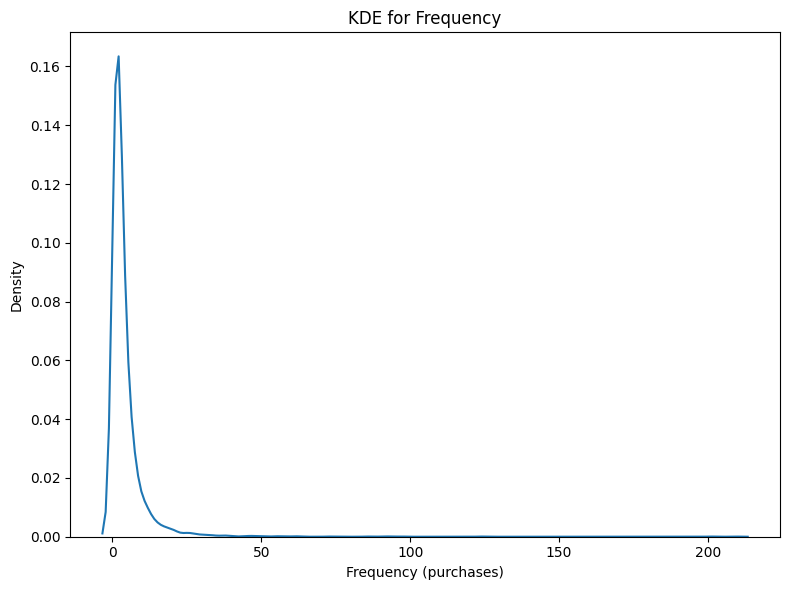

In [47]:
fig, ax = plt.subplots(figsize=(8.0, 6.0), layout="tight")
ax = cast(Axes, ax)
sns.kdeplot(data=df_rfm, x="Frequency", ax=ax)
ax.set_title("KDE for Frequency")
ax.set_xlabel("Frequency (purchases)")
plt.show()

### Monetary value and M score

In this case, each bin has approximately the same number of customers:

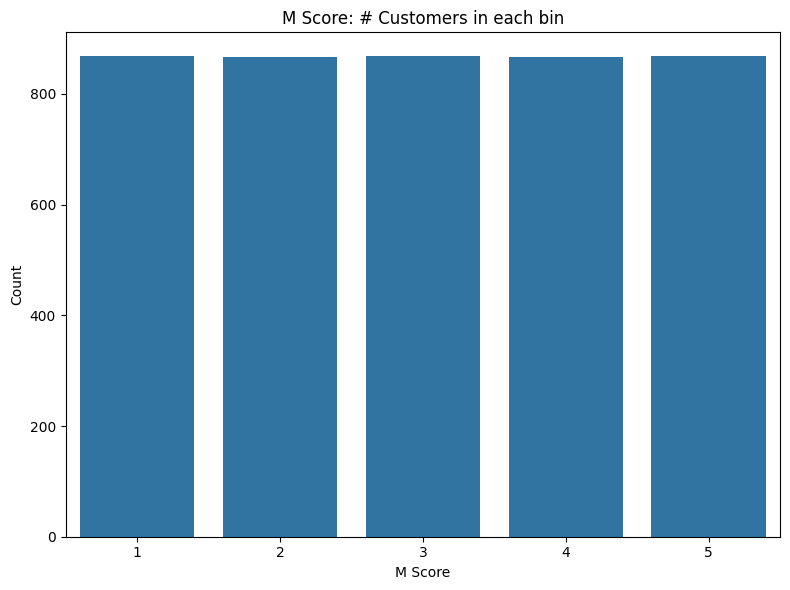

In [48]:
plot_bin_count(df_rfm, "M")

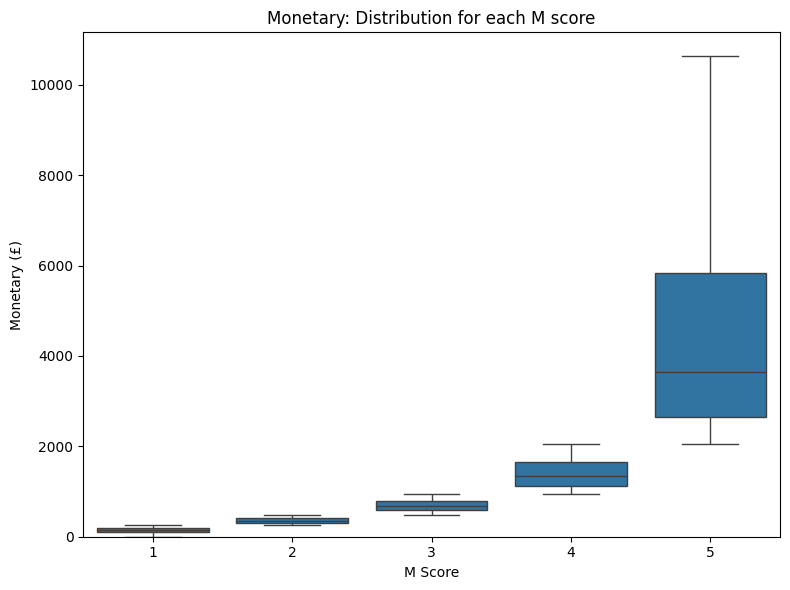

In [49]:
plot_distribution_by_score(df_rfm, "Monetary")

## Summarizing through functions

The RFM analysis isn't complete yet. But I've already achieved my goal for
this notebook. As usual, I'll conclude by writing a couple of functions that
summarize what I just did.

In [50]:
def compute_and_save_rfm_scores(file_path: Path, num_bins: int = 5) -> None:
    prepared_data = read_prepared_data(file_path)
    df_rfm = compute_rfm_attributes(prepared_data)
    df_rfm = add_rfm_scores(df_rfm, num_bins)
    out_file = file_path.parent / f"rfm_scores_{num_bins}.csv"
    df_rfm.to_csv(out_file, index=True)

In [51]:
# compute_and_save_rfm_scores(Path.cwd().parents[1] / "data" / "online_retail.csv", num_bins=5)

In [52]:
def plot_rfm_attributes_and_scores(
    df: pd.DataFrame,
    figsize: tuple[float, float] = (8.0, 6.0),
) -> None:
    attrs = get_args(RFMAttribute)
    for score in (attr[0] for attr in attrs):
        plot_bin_count(df, score, save=True, figsize=figsize)
    for attr in attrs:
        plot_distribution_by_score(df, attr, save=True, figsize=figsize)

In [53]:
plot_rfm_attributes_and_scores(df_rfm)